<h1>A model workflow for MOLASSES, the lava flow simulator </h1>

MOLASSES is designed to give a flow model given a set of eruption source parameter.

Three key numerical inputs must be entered  
1. The lava flow residual thickness, or the thickness at rest (in meters)
2. The total volume of the effusive eruption (in $m^3$)
3. the lava flow of each pulse during the eruption (in $m^3$), which will be some fraction of the total volume.

Additionally, A DEM (Digital Elevation Model) is required for proper simulation.

Finally, an event file should be supplied.

Optionally, you can set more runs of the simulation to test/include minor variations. Keep in mind, each run will add a significant amount of runtime to the simulation.

In [1]:
import os
import numpy as np
import rasterio as rio
from rasterio.plot import show
import subprocess
import pandas as pd
import warnings
import cartopy.crs as ccrs
import pyproj
import matplotlib.pyplot as plt
import rioxarray as rxr
import sys
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
sys.path.insert(0, "/home/jovyan/shared/Libraries/")
import victor

### Key Parameters

Here, please input your preferred residual thickness, total volume, and pulse volume, along with the DEM filepath and events in UTM coordinates

In [3]:
#Input residual thickness (meters)
residual = 20

#input total volume (meters, standard or scientific notation both acceptable)
total_volume = 1e8

#input pulse volume (meters, standard or scientific notation both acceptable)
pulse_volume = 1e5
#input DEM file (string, relative path to file)
dem = "Molasses_test.asc"

#input UTM location of event location(easting,northing with NO SPACE between values),
# with a space in between multiple events
events = "366165,4820531 365165,4823531"

#OPTIONAL (default 1), add runs (integer)
runs = []


### Let's confirm your DEM works! 

You can run the next three cells without any changes. This will set up the input file correctly for MOLASSES. We'll also display your DEM to make sure you get what you're expecting.

In [4]:
coordinates = events.replace(',', ' ')
coordinates = coordinates.split(" ")
coordinates = [int(coords) for coords in coordinates]
coordinates = np.asarray(np.reshape(coordinates,(int(len(coordinates)/2),2)))

In [5]:
events_file = open("events.in",'w')
events_file.write(events)
events_file.close()

with open("custom_molasses.conf", "w") as f:
    print("PARENTS = 1", file=f)
    print(f"ELEVATION_UNCERT = 0", file=f)
    print(f"MIN_RESIDUAL = {residual}", file=f)
    print(f"MAX_RESIDUAL = {residual}", file=f)
    print(f"MIN_TOTAL_VOLUME = {total_volume}", file=f)
    print(f"MAX_TOTAL_VOLUME = {total_volume}", file=f)
    print(f"MIN_PULSE_VOLUME = {pulse_volume}", file=f)
    print(f"MAX_PULSE_VOLUME = {pulse_volume}", file=f)
    print(f"RUNS = {1 if not runs else runs}", file=f)
    print(f"ASCII_FLOW_MAP = 1", file=f)
    print(f"DEM_FILE = {dem}", file=f)
    print(f"EVENTS_FILE = events.in", file=f)

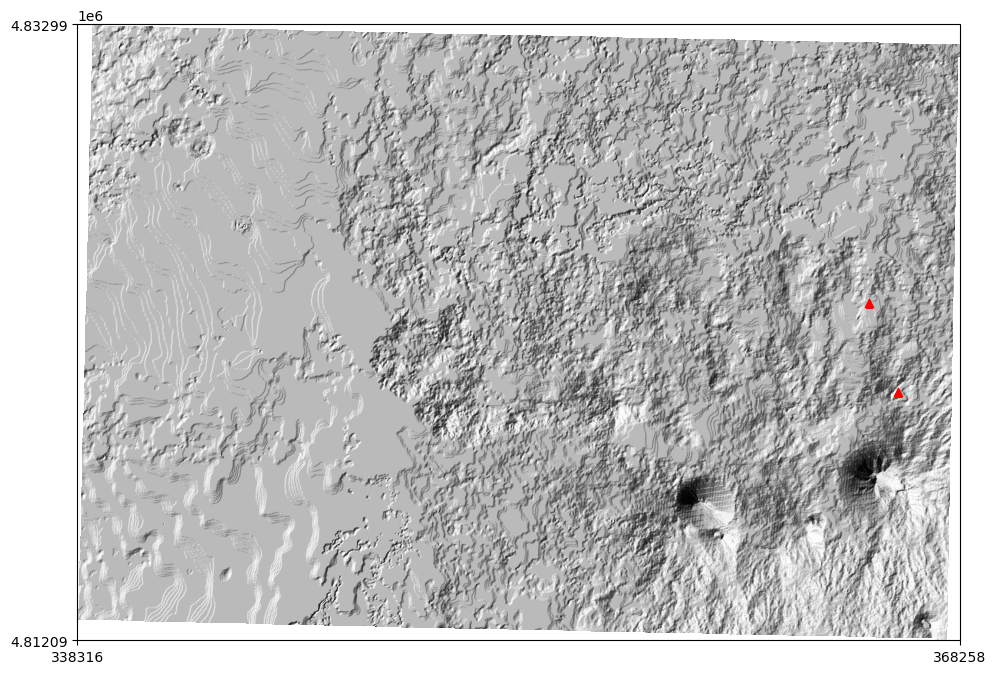

In [6]:
victor.plot_dem(dem,coordinates)

### Now that all the values are configured, you can now run the model. 

This could take a while, so be patient! Note that a return code of 0 is expected. Other return values or an instantaneous run will signify an error.

For a complete output (warning, large amounts of text), replace the next line with `subprocess.run("./molasses_2022 ./custom_molasses.conf",shell=True)`.

In [7]:
subprocess.run("./molasses_2022 ./custom_molasses.conf",shell=True, stdout=subprocess.DEVNULL)

Checking for missing parameters ....
Allocating Memory for Active Cell List, Active list size: 1566908, uint max: 4294967295, int max: 2147483647
----------------------------------------

Writing output file: 

Not printing type = 1
Not printing type = 2
Not printing type = 3
Not printing type = 4
Not printing type = 5
Not printing type = 6


CompletedProcess(args='./molasses_2022 ./custom_molasses.conf', returncode=0)

### Now that this has finished running, we are able to generate and plot an image that we can then display. 

You may choose either a full view of the DEM, or a focus in just the immediate area around the lava flow. Select this below. The final cell will overlay the final results over the DEM. To adjust the plot size or to change the projection, please alter the respective lines in the final cell.

In [8]:
#zoom: True = cropped around flow, False = default DEM bounds
zoom = True

In [9]:
colnames=['EAST', 'NORTH', 'THICKNESS', 'NEW_ELEV', 'ORIG_ELEV'] 
lava = pd.read_csv('./flow_-0', skiprows=3, names=colnames, delim_whitespace=True, header= None)
coords = pd.read_csv('./flow_-0', skiprows=1,nrows=1, delim_whitespace=True, header= None)
lava.to_csv("flow.csv",header=colnames,index=False)
lava.to_csv("plot_flow.csv",header=None,index=False)

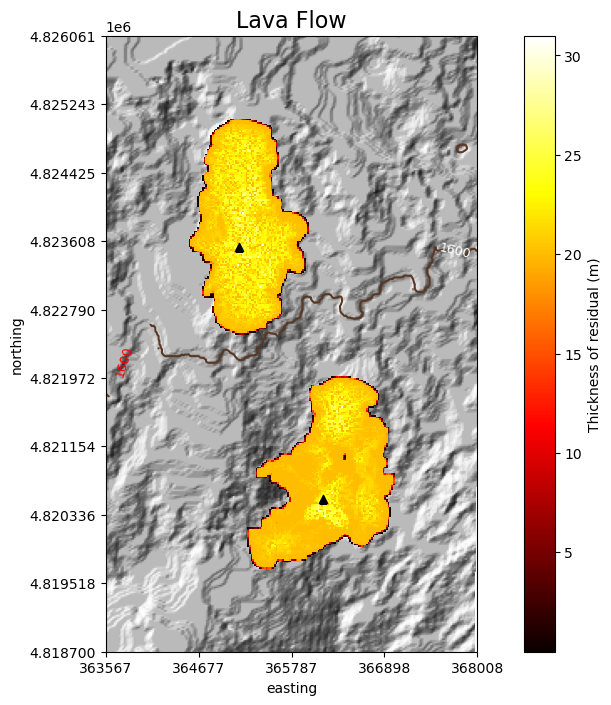

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.epsg(32628))
victor.plot_flow(dem, "plot_flow.csv", axes=ax, coords=coordinates, zoom=zoom)

In [ ]:
os.remove("flow_-0")